In this notebook, you will
- Learn how to use `Linop`, `Prox`, and `Alg` to create an `App`
- Create a Fourier compressed sensing `App`

SigPy provides abstractions for linear operator, proximal operator and iterative algorithms. This is similar to how BART abstracts the iterative reconstruction. By dividing functions into these three classes, many components can be reused, and code can be drastically shortened.

![architecture](https://sigpy.readthedocs.io/en/latest/_images/architecture.pdf)

In [2]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

The problem we are interested in solving in this tutorial is the following:
$$\min_x \frac{1}{2} \| P F x - y \|_2^2 + \lambda \| W x \|_1$$
where $P$ is the sampling operator, $F$ is the Fourier transform operator, $W$ is the wavelet transform operator, $x$ is the image and $y$ is the acquired k-space measurements.

# Linop

https://sigpy.readthedocs.io/en/latest/core_linop.html

<IPython.core.display.Javascript object>


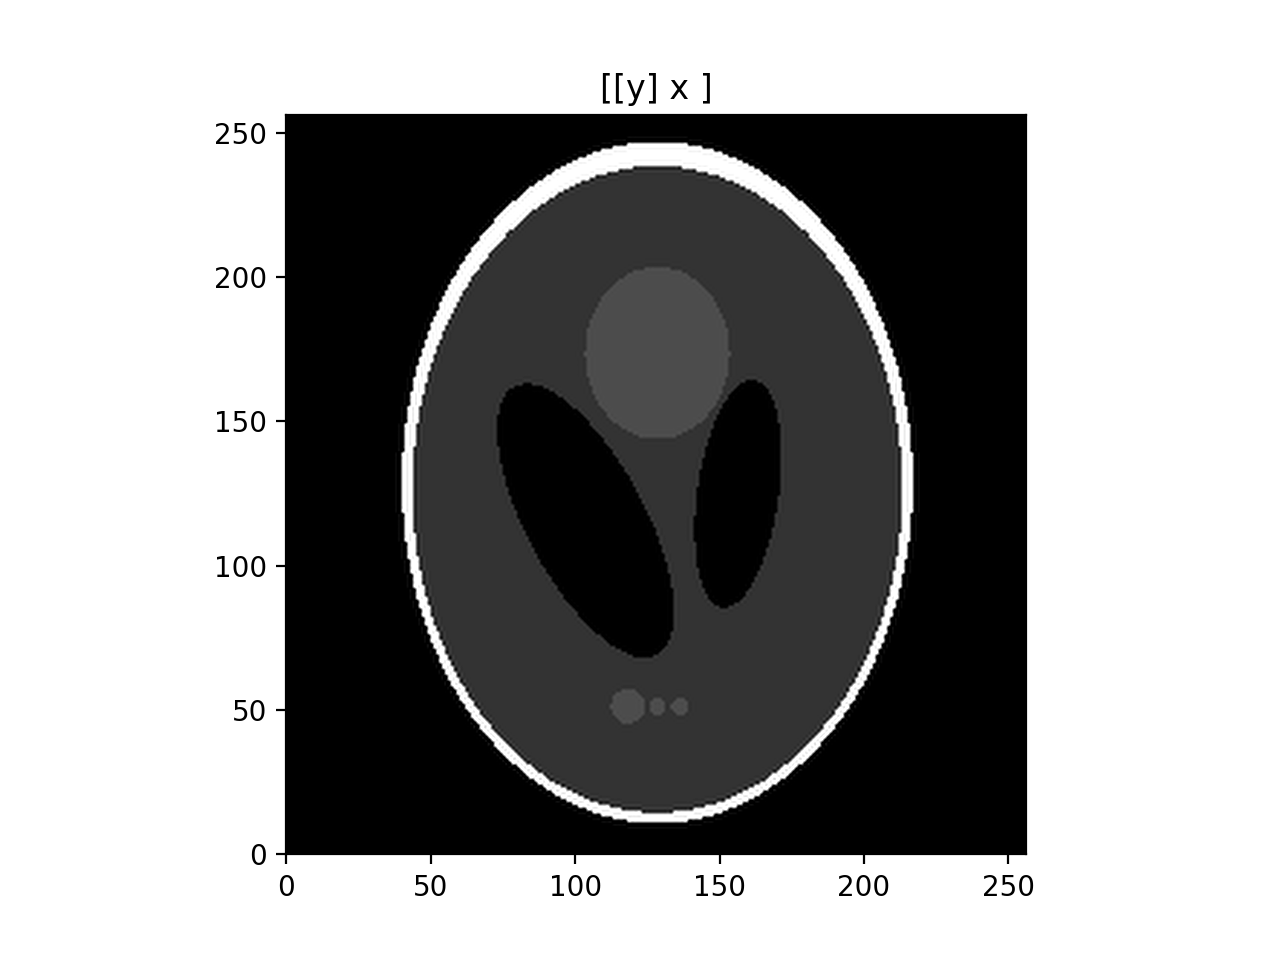

In [3]:
x_shape = [256, 256]
x = sp.shepp_logan(x_shape)

pl.ImagePlot(x)

<IPython.core.display.Javascript object>


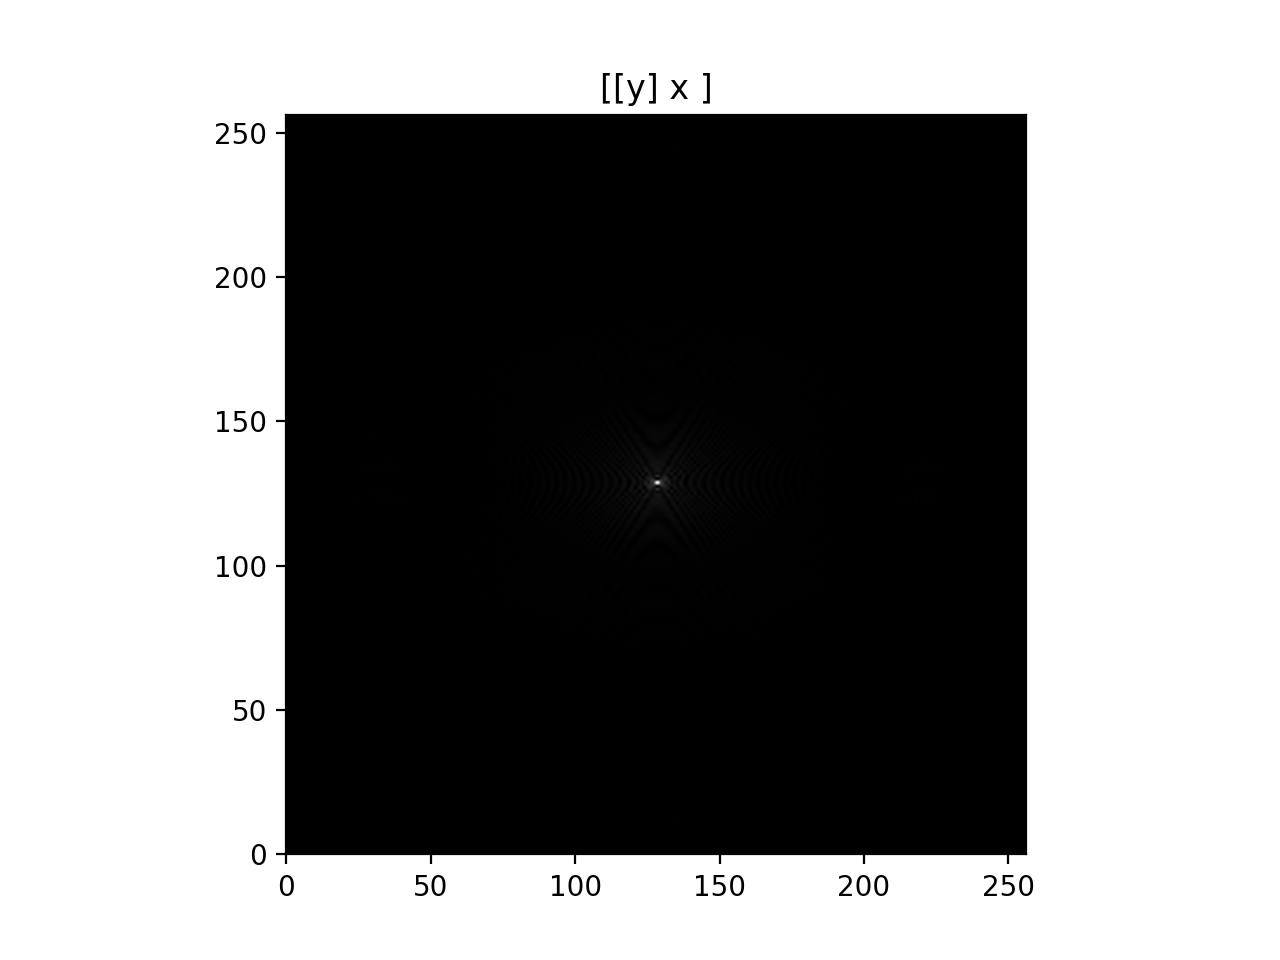

In [4]:
F = sp.linop.FFT(x_shape)
y = F * x # Alternatively can also do F(x)

pl.ImagePlot(y)

## Adjoint

<IPython.core.display.Javascript object>


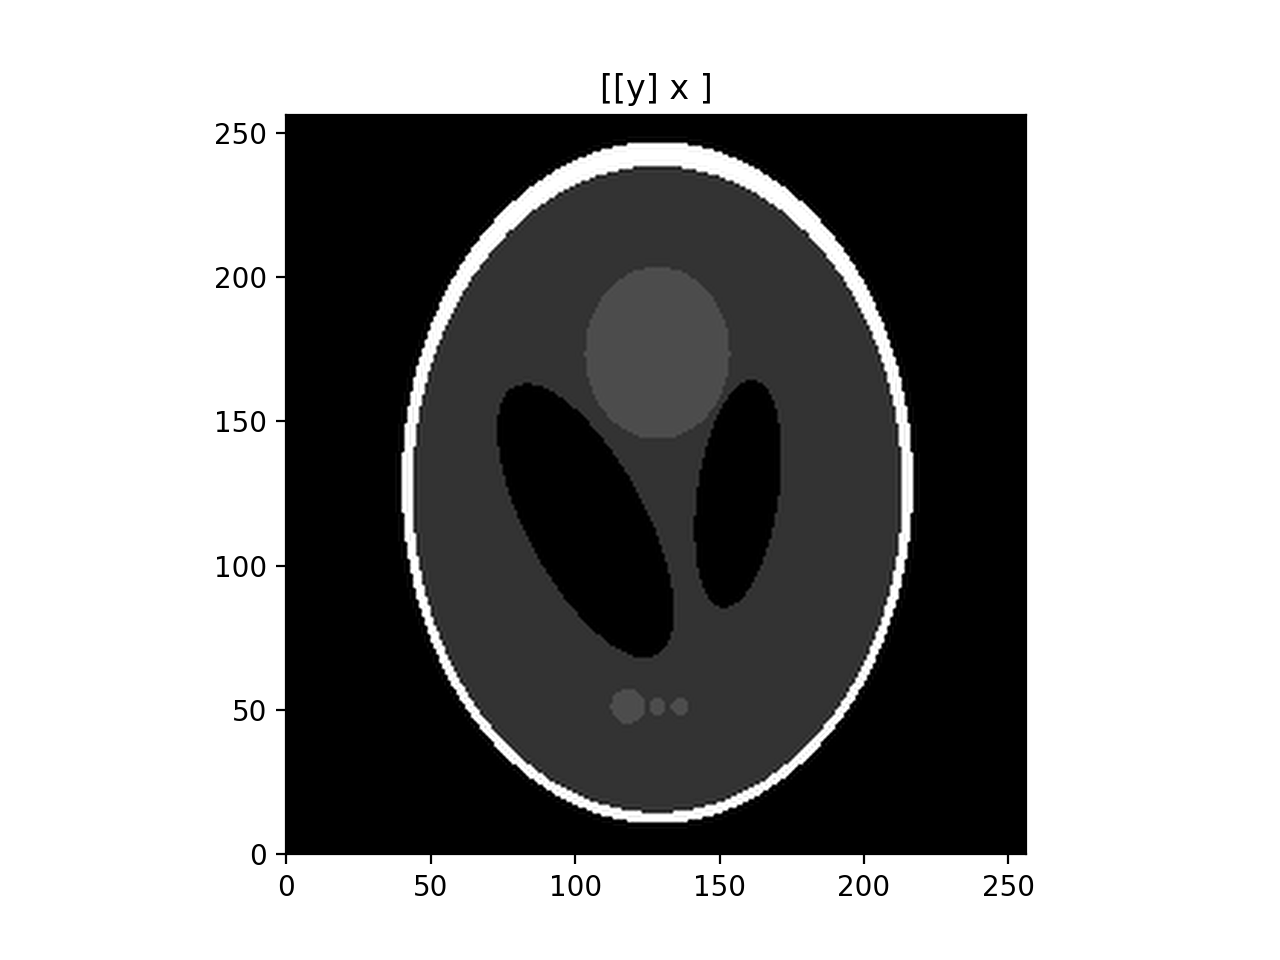

In [5]:
x_hat = F.H * y

pl.ImagePlot(x_hat)

## Chaining Linops

<IPython.core.display.Javascript object>


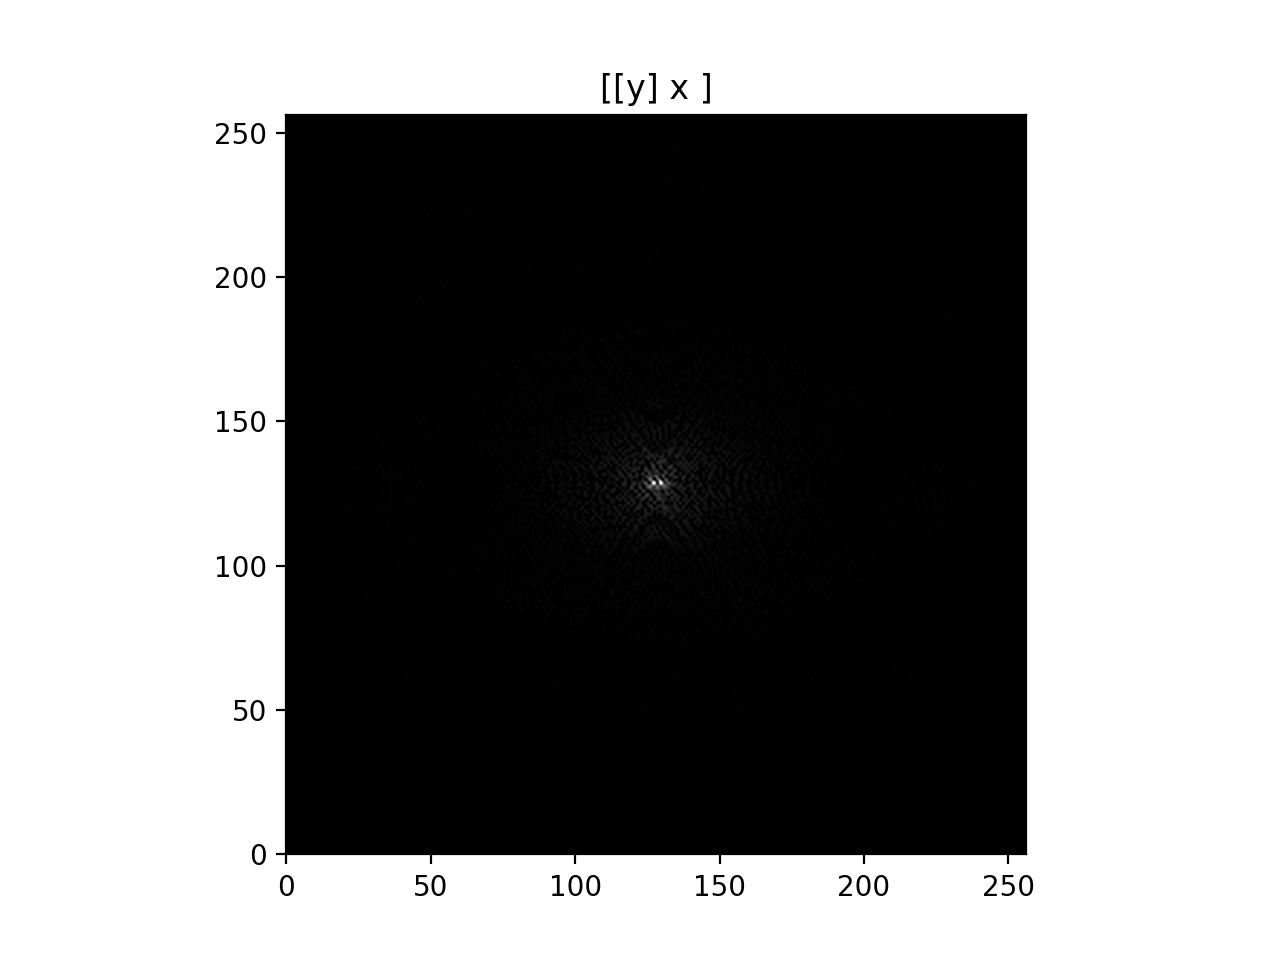

In [6]:
accel = 3

mask = mr.poisson(x.shape, accel)
P = sp.linop.Multiply(x.shape, mask)

y_u = P * y
pl.ImagePlot(y_u)

<IPython.core.display.Javascript object>


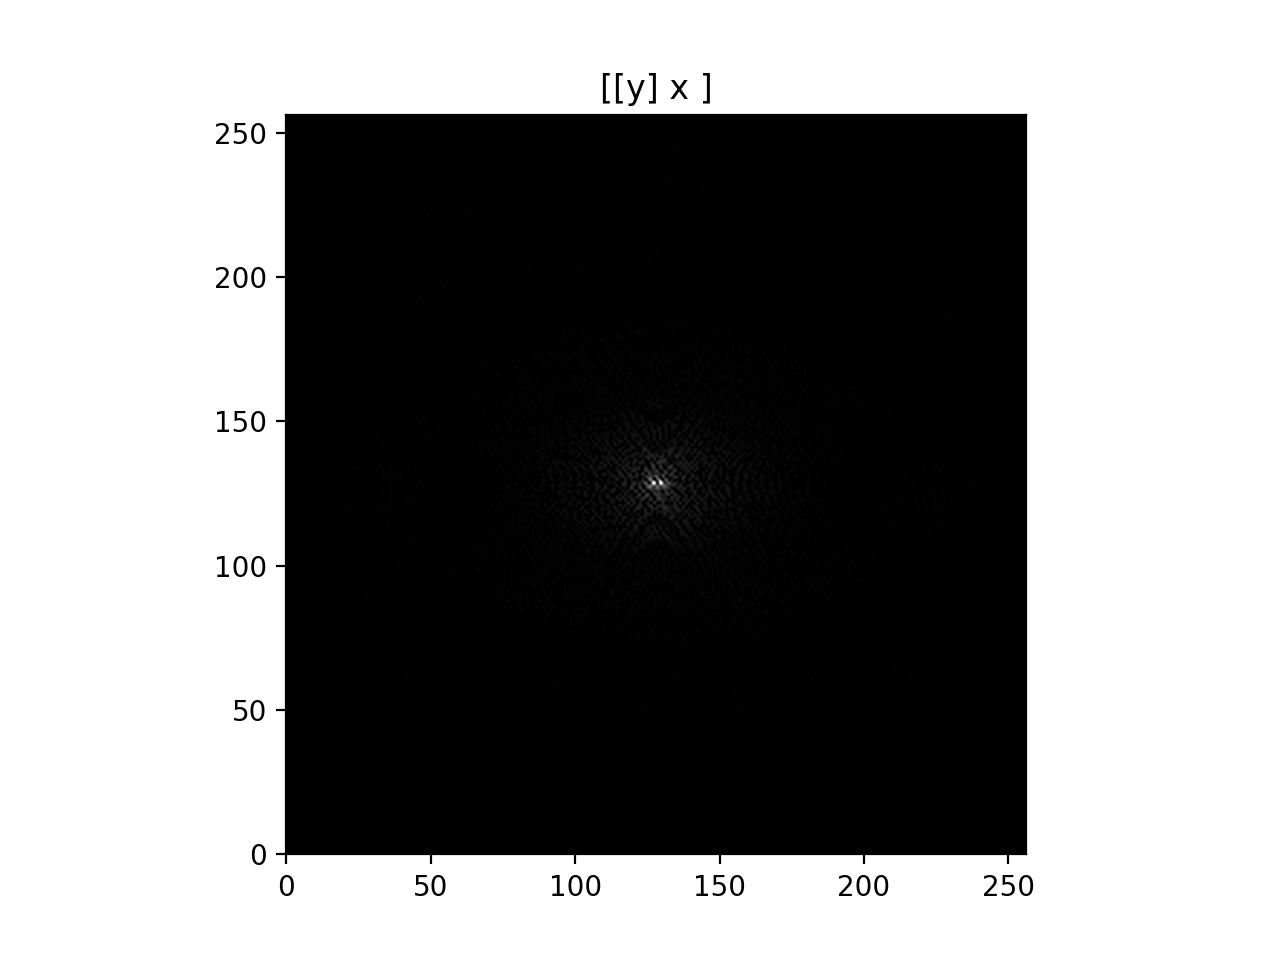

In [8]:
A = P * F
y_u = A * x
pl.ImagePlot(y_u)

<IPython.core.display.Javascript object>


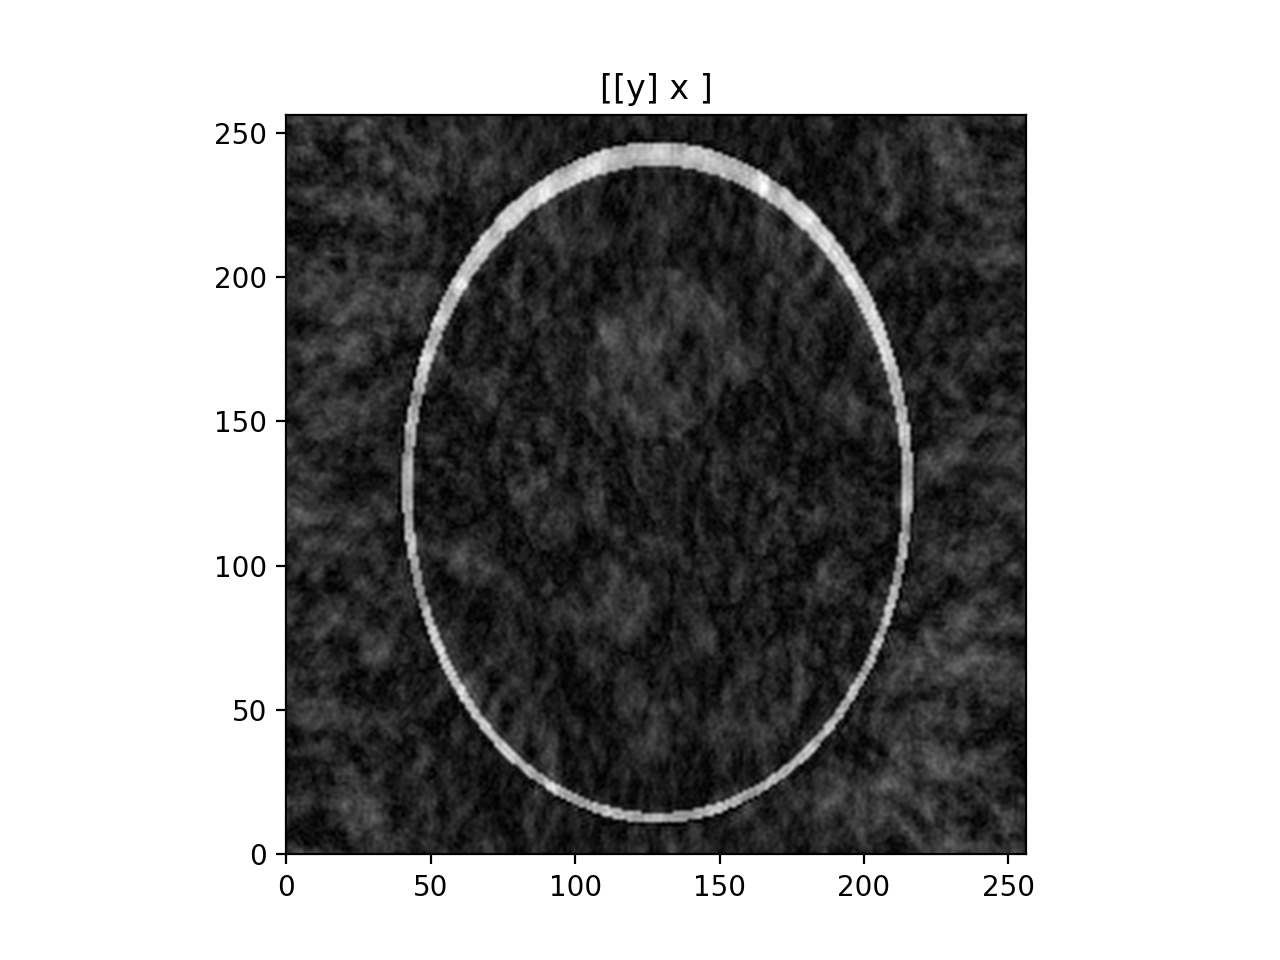

In [9]:
x_u = A.H * y_u

pl.ImagePlot(x_u)

<IPython.core.display.Javascript object>


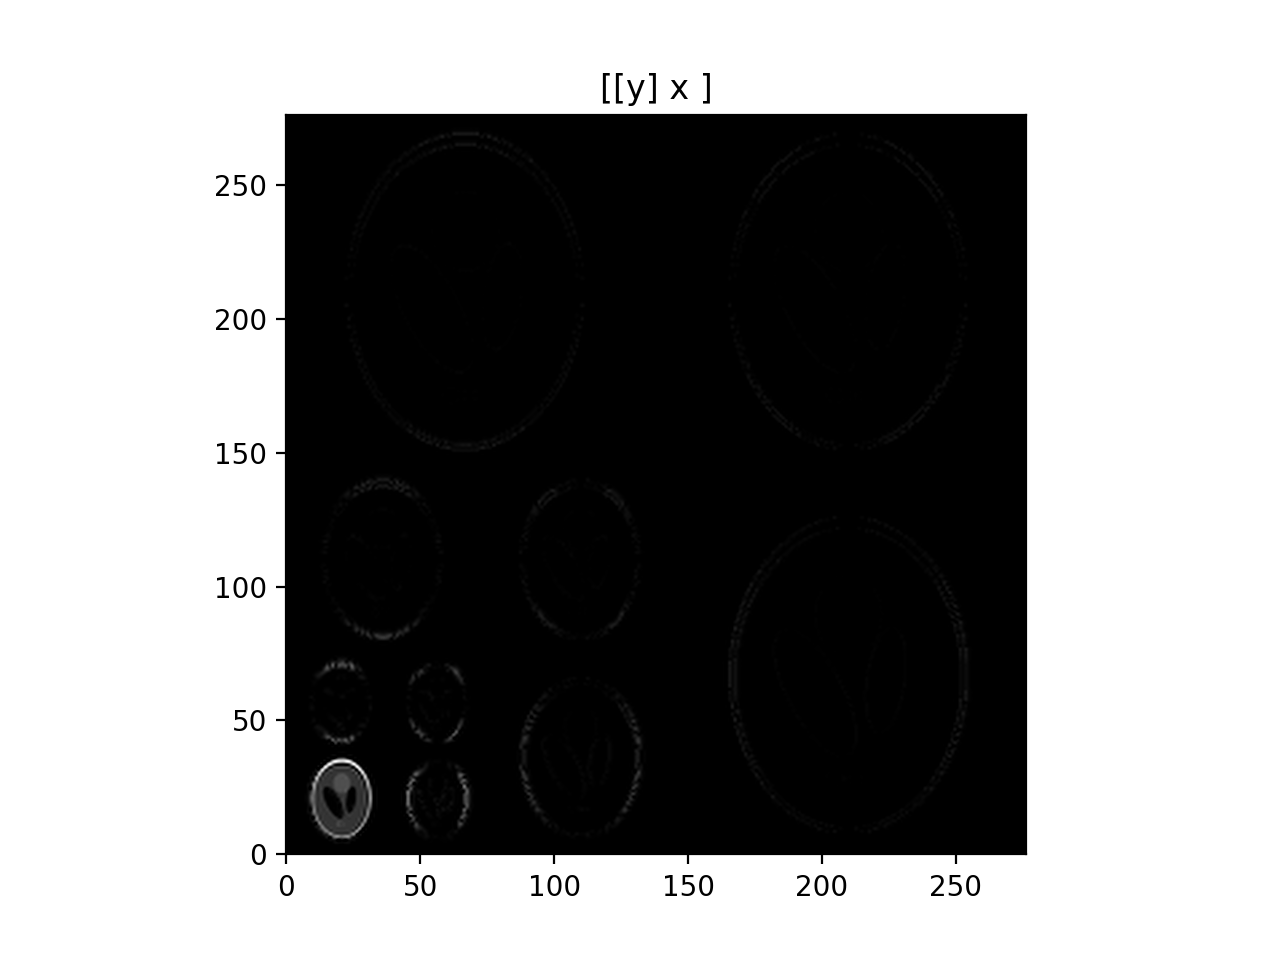

In [10]:
W = sp.linop.Wavelet(x.shape, level=3)
wav = W * x
pl.ImagePlot(wav)

# Prox

https://sigpy.readthedocs.io/en/latest/core_prox.html

<IPython.core.display.Javascript object>


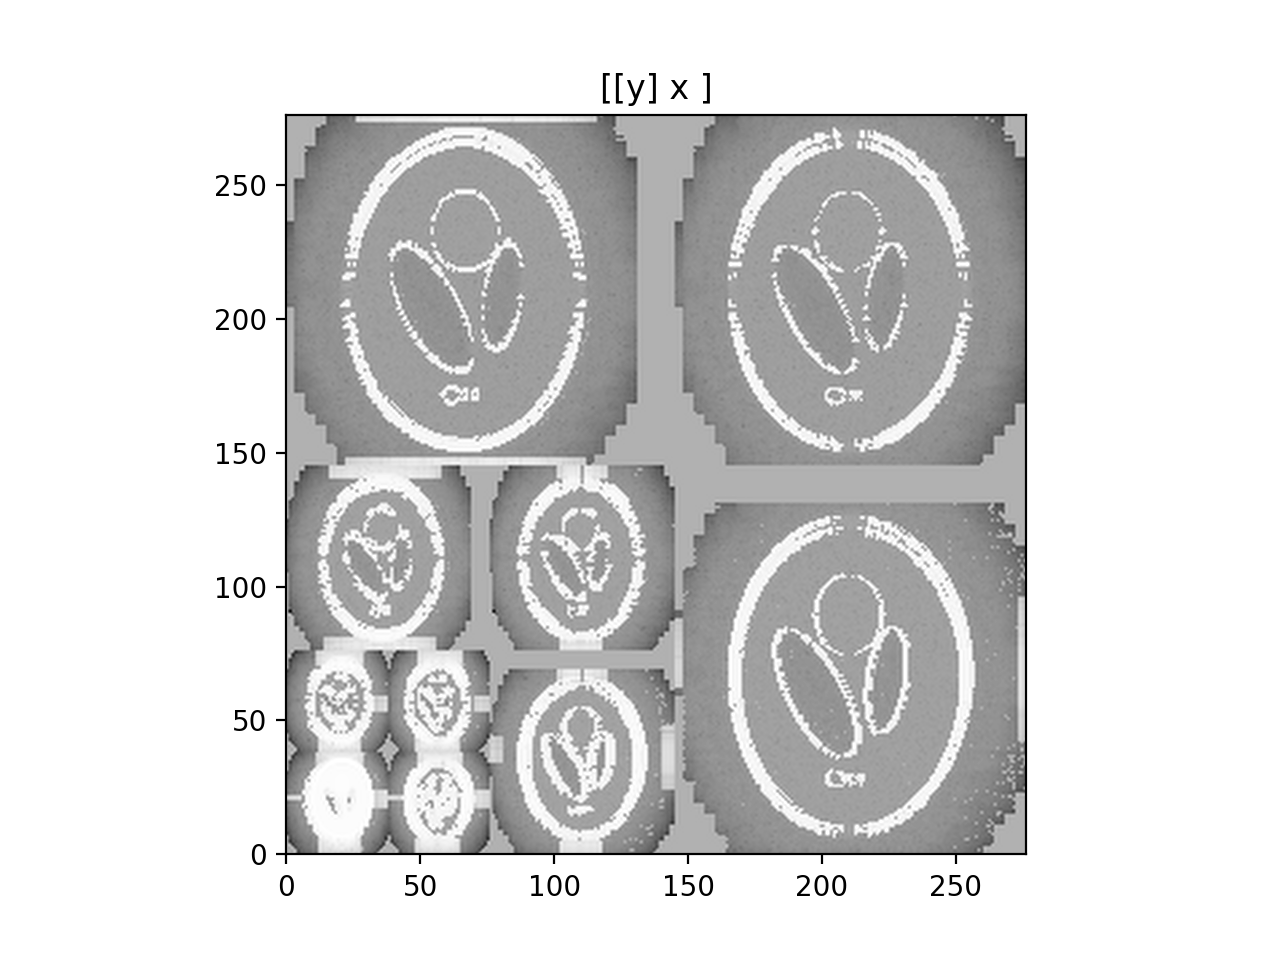

In [77]:
lamda = 0.01
proxg = sp.prox.L1Reg(wav.shape, lamda)
proxg = sp.prox.UnitaryTransform(proxg, W)
alpha = 1
x_thresh = proxg(alpha, x)

pl.ImagePlot(W * x_thresh)

# Alg

https://sigpy.readthedocs.io/en/latest/core_alg.html

In [92]:
max_iter = 100
alpha = 1

def gradf(x):
    return F.H * (F * x - y)

x_hat = np.zeros(x.shape, np.complex)
alg = sp.alg.GradientMethod(gradf, x_hat, alpha, proxg=proxg, 
                            max_iter=max_iter, accelerate=True)

In [93]:
while not alg.done():
    alg.update()
    print(alg.iter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


<IPython.core.display.Javascript object>


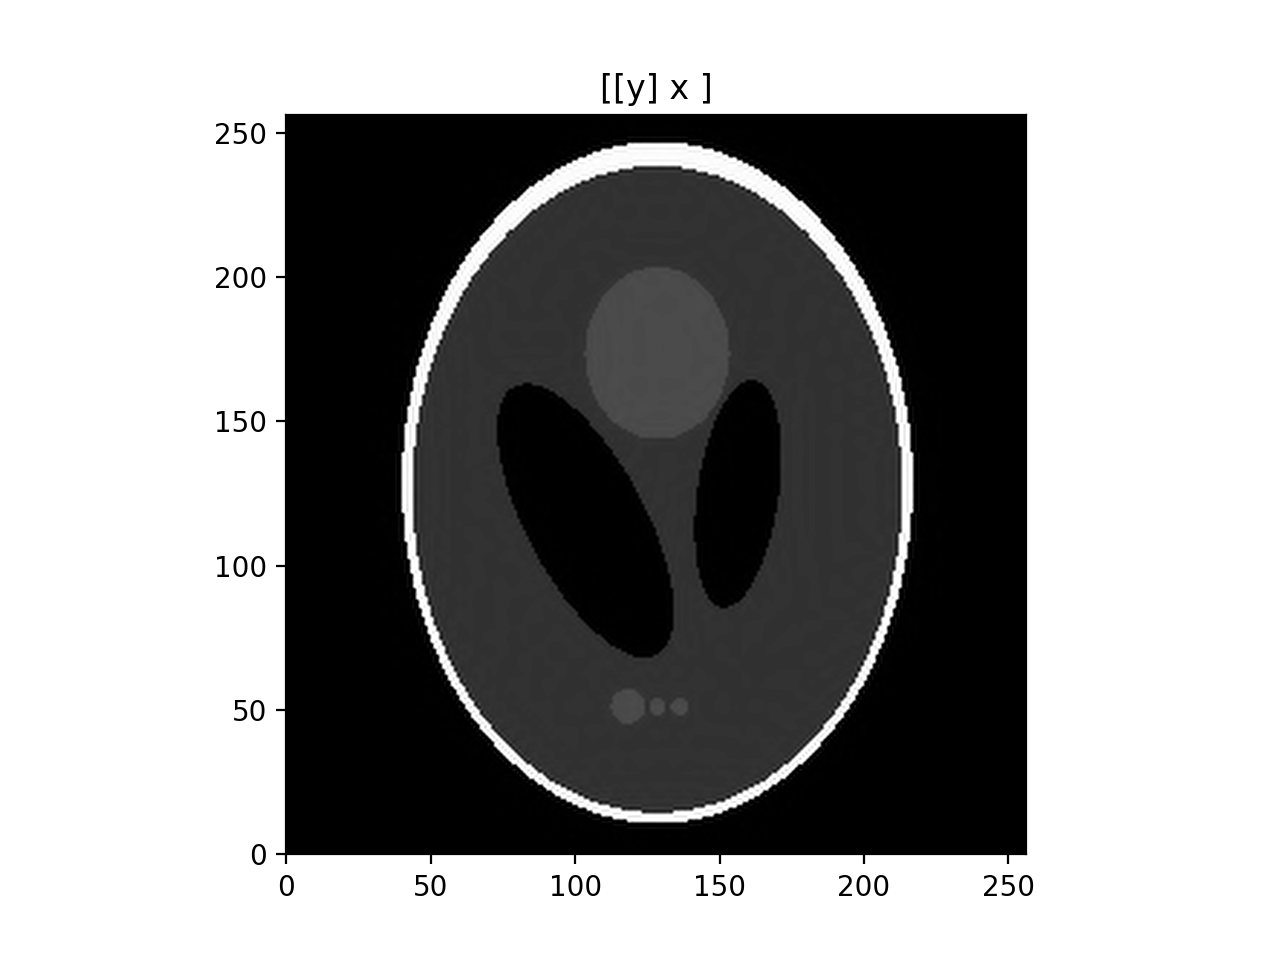

In [82]:
pl.ImagePlot(x_hat)

# App

In [83]:
class FourierCompressedSensing(sp.app.App):
    def __init__(self, y, mask, lamda, max_iter):
        x_shape = y.shape
        
        # 
        F = sp.linop.FFT(x_shape)
        P = sp.linop.Multiply(x_shape, mask)
        A = P * F
        
        proxg = sp.prox.L1Reg(W.oshape, lamda)
        proxg = sp.prox.UnitaryTransform(proxg, W)
        
        self.x_hat = np.zeros(x_shape, np.complex)
        alpha = 1
        alg = sp.alg.GradientMethod(gradf, self.x_hat, alpha, proxg=proxg, 
                                    max_iter=max_iter, accelerate=True)
        super().__init__(alg)
        
    def _output(self):
        return self.x_hat

In [84]:
x_hat = FourierCompressedSensing(y, mask, lamda, max_iter).run()


FourierCompressedSensing:  87%|████████▋ | 87/100 [00:01<00:00, 42.08it/s]


FourierCompressedSensing: 100%|██████████| 100/100 [00:02<00:00, 45.14it/s]

<IPython.core.display.Javascript object>


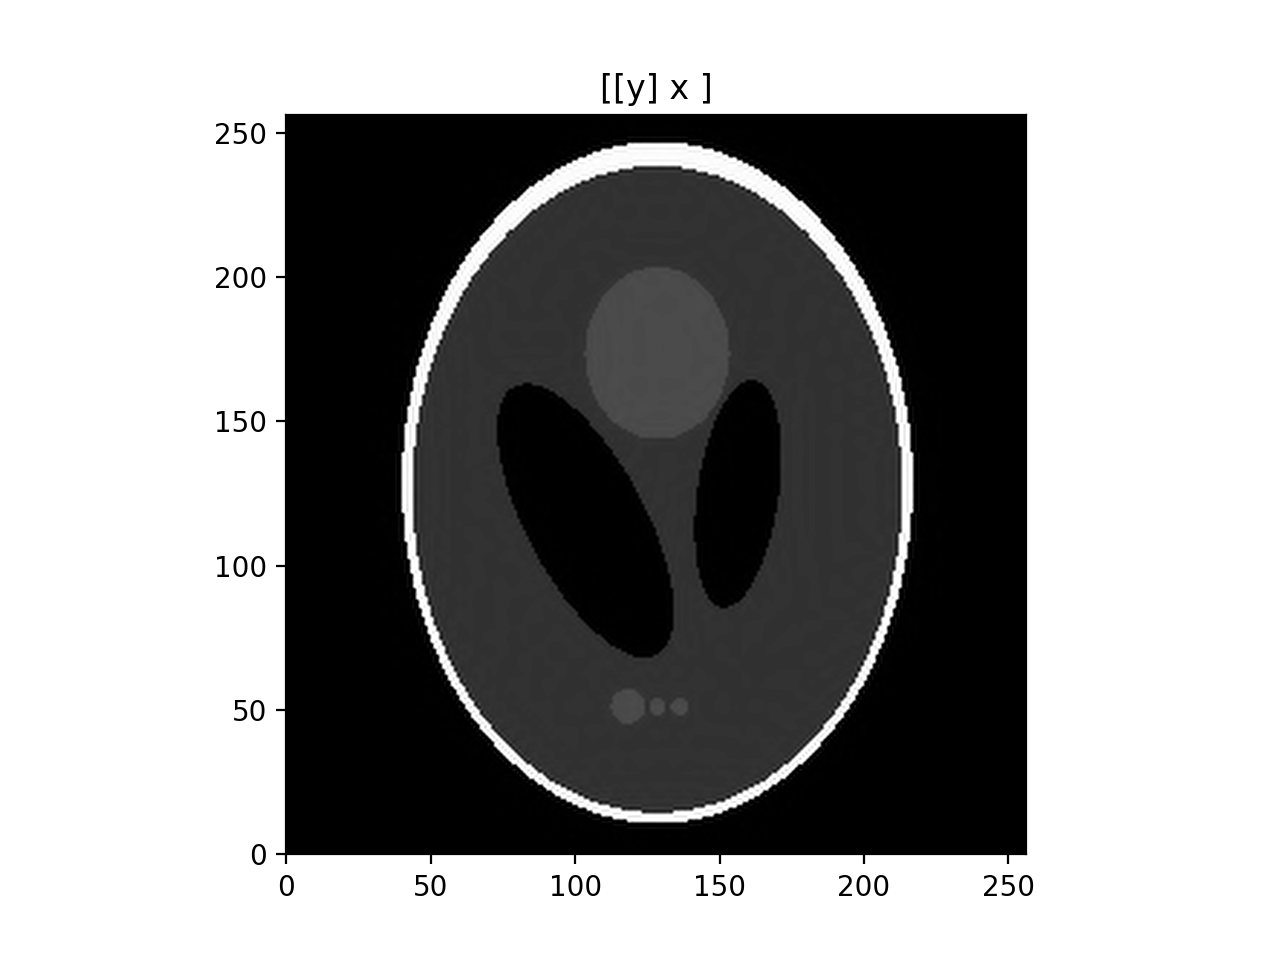

In [85]:
pl.ImagePlot(x_hat)